***Plot the probability distributions of the pose of a marker***
Each observation implies a marker position in the world frame, if the nominal robot model is assumed exact. This script calculates the would be pose of the marker from each observation, and plots a curve approximateing an underlying PDF

In [1]:
import pickle
import numpy as np
from parameter_estimator import ParameterEstimator
import utils
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import nominal positions of markers
with open('points.p', 'rb') as f:
    pointlist = pickle.load(f)  # deserialize using load()

nominal_locations = {}
nominal_locations_rounded = {}
for i, point in enumerate(np.array(pointlist).T):
    nominal_locations[i+1] = np.concatenate((point[0:3], np.zeros(1), point[3:5]))
    nominal_locations_rounded[i+1] = np.around(nominal_locations[i+1], 4)
#     print(f"{i+1}: {nominal_locations[i+1]}")
#     print(f"{i+1}: {nominal_locations_rounded[i+1]}\n")

    

In [3]:
# import observations from file

# select observations file
observations_file_select = 6
observations_file_str_dict = {1: r'observation_files/obs_2007_gazebo_iiwa_stopping.bag_20230720-135812.p',  # works
                              2: r'observation_files/obs_2007_gazebo_iiwa_stopping.bag_20230720-135812_filtered.p',
                              4: r'observation_files/obs_2007_gazebo_.p',  # works
                              5: r'observation_files/obs_bag_with_lockstep_281023_2023-10-28-14-01-49_20231028-142947.p',
                              6: r'observation_files/obs_single_marker_2023-11-01-11-12-21_20231101-112227.p',
                              9: r'observation_files/observations_simulated_w_error_0mm_0deg_num24020231020_163148.p',
                              10: r'observation_files/observations_simulated_w_error_0.5mm_0.5deg_num24020231020_164948.p',
                              11: r'observation_files/observations_simulated_w_error_5mm_5e-05deg_num24020231027_095006.p',
                              12: r'observation_files/observations_simulated_w_error_7mm_5e-05deg_num24020231027_095120.p',
                              13: r'observation_files/observations_simulated_w_error_1mm_1deg_num24020231027_111510.p',
                              14: r'observation_files/observations_simulated_w_error_1mm_0.1deg_num24020231027_111600.p'}

observations_file = open(observations_file_str_dict[observations_file_select], 'rb')
observations = pickle.load(observations_file)
observations_file.close()
print(observations.keys())

dict_keys([2, 1, 4, 7, 5])


In [66]:
from scipy.spatial.transform import Rotation as R
def H_rvec_tvec_scipy(rvec, tvec):
    r = R.from_rotvec(rvec)
    rotmat = r.as_matrix()
    H = utils.toHomogeneous(rotmat, tvec)
    return H

def mat2rvectvec_scipy(mat):
    r = R.from_matrix(mat[0:3, 0:3])
    rvec = r.as_rotvec()
    tvec = mat[0:3, 3]
    return rvec, tvec

def mat2eulertvec_scipy(mat):
    r = R.from_matrix(mat[0:3, 0:3])
    rvec = r.as_euler('xyz')
    tvec = mat[0:3, 3]
    return rvec, tvec

def get_diff_of_angles(x,y):
    from math import atan2, sin, cos
    return (atan2(sin(x-y), cos(x-y))+np.pi/2)%np.pi-np.pi/2

def calc_tvec_rvec_error(tvec1, tvec2, rvec1, rvec2):
    rdiff = [get_diff_of_angles(x,y) for x,y in zip(rvec1, rvec2)]
    return np.concatenate((np.array(tvec2)-np.array(tvec1), np.array(rdiff)))
        

 1.000  0.000  0.000  0.000 

 0.000 -1.000  0.000  0.000 

 0.000  0.000 -1.000  0.000 

 0.000  0.000  0.000  1.000 





In [67]:
calc_error(np.array([1,2,3]), np.array([4,5,6]), np.array([np.pi-0.1, np.pi/2, 0]), np.array([np.pi+0.1, np.pi/2, 0]))

array([3. , 3. , 3. , 0.2, 0. , 0. ])

In [70]:
pe = ParameterEstimator()

theta = ParameterEstimator.dhparams["theta_nom"].astype(float)
d = ParameterEstimator.dhparams["d_nom"].astype(float)
r = ParameterEstimator.dhparams["r_nom"].astype(float)
alpha = ParameterEstimator.dhparams["alpha_nom"].astype(float)

marker_id = []

x = []
y = []
z = []
a = []
b = []
c = []

xn = []
yn = []
zn = []
an = []
bn = []
cn = []

dist_errors = []
for marker in observations:
    if marker == 0 or marker>21: continue
    
    print(f'{marker} len: {len(observations[marker])}')
    # print(f'#### MARKER {marker} ####\n')
    for obs in observations[marker]:
        q = np.hstack((np.array(obs["q"]), np.zeros(1)))
        T_CM = pe.T_corr @ utils.H_rvec_tvec(obs["rvec"], obs["tvec"]) @ np.linalg.inv(pe.T_corr)
        T_CM2 = pe.T_corr @ H_rvec_tvec_scipy(obs["rvec"], obs["tvec"]) @ np.linalg.inv(pe.T_corr)

        # calculate nominal transforms
        T_08 = pe.get_T_jk(0, 8, q, theta, d, r, alpha)

        T_WM = pe.T_W0 @ T_08 @ T_CM
        T_WM2 = pe.T_W0 @ T_08  @ T_CM2 @ pe.T_correct_cam_mdh
        # utils.roundprint(T_WM)
        rvec, tvec = utils.mat2rvectvec(T_WM)
        rvec2, tvec2 = mat2eulertvec_scipy(T_WM2)
        dist_error = np.concatenate((tvec-nominal_locations[marker][0:3], rvec-nominal_locations[marker][3:6]))
        dist_error = calc_tvec_rvec_error(tvec2, nominal_locations[marker][0:3], rvec2, nominal_locations[marker][3:6])
        if marker == 4:
            #print(q)
            #print(f"identified (r, t): \n{np.array(rvec)}\t{np.array(tvec)}")
            #print(f"identified2 (r, t): \n{np.array(rvec2)}\t{np.array(tvec2)}")
            #print(f"true (r, t): \n{np.array(nominal_locations[marker][3:6])}\t{np.array(nominal_locations[marker][0:3])}")
            #print("\n")
            dist_errors.append(dist_error)
        marker_id.append(marker)
        x.append(tvec[0])
        y.append(tvec[1])
        z.append(tvec[2])
        a.append(rvec[0])
        b.append(rvec[1])
        c.append(rvec[2])
        
        xn.append(nominal_locations[marker][0])
        yn.append(nominal_locations[marker][1])
        zn.append(nominal_locations[marker][2])
        an.append(nominal_locations[marker][3])
        bn.append(nominal_locations[marker][4])
        cn.append(nominal_locations[marker][5])

        # int(f'{rvec} {tvec}')

2 len: 59
1 len: 27
4 len: 810
7 len: 28
5 len: 89


(array([ 0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  2.,  3.,  5., 13., 13.,
        18., 34., 29., 37., 66., 83., 86., 78., 81., 62., 54., 42., 44.,
        20., 16.,  7.,  7.]),
 array([-0.01      , -0.00933333, -0.00866667, -0.008     , -0.00733333,
        -0.00666667, -0.006     , -0.00533333, -0.00466667, -0.004     ,
        -0.00333333, -0.00266667, -0.002     , -0.00133333, -0.00066667,
         0.        ,  0.00066667,  0.00133333,  0.002     ,  0.00266667,
         0.00333333,  0.004     ,  0.00466667,  0.00533333,  0.006     ,
         0.00666667,  0.00733333,  0.008     ,  0.00866667,  0.00933333,
         0.01      ]),
 <BarContainer object of 30 artists>)

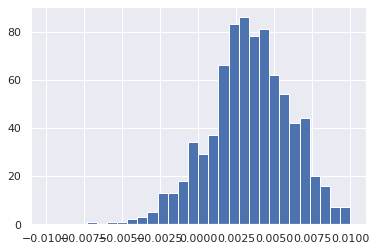

In [85]:
dist_errors= np.array(dist_errors)
bins=(np.arange(0,31)-15)/1500
plt.hist(dist_errors[:,4], bins=bins)

In [8]:
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['z'] = z
df['a'] = a
df['b'] = b
df['c'] = c
df['marker_id'] = marker_id
df['xn'] = xn
df['yn'] = yn
df['zn'] = zn
df['an'] = an
df['bn'] = bn
df['cn'] = cn

In [9]:
sns.set()

In [10]:
# for marker in observations:
#     for pos_coordinate in ['x', 'y', 'z']:
#         sns.displot(df[df['marker_id']==marker], x=pos_coordinate, kind="kde")
        
# axvlines don't work well with the plot type used by seaborn
#plt.axvline(x=nominal_locations[3][0])
#plt.axvline(x=nominal_locations_rounded[3][0])

In [11]:
# print the standar deviation for all coordinates
for m in set(marker_id):
    print(f'marker {m}:')
    print(df[df['marker_id']==m].std())
    print('\n')

marker 1:
x            3.561790e-02
y            7.496689e-04
z            1.123683e-02
a            2.237041e-03
b            4.198820e-03
c            4.388942e-03
marker_id    0.000000e+00
xn           4.525488e-16
yn           0.000000e+00
zn           0.000000e+00
an           0.000000e+00
bn           0.000000e+00
cn           0.000000e+00
dtype: float64


marker 2:
x            1.277598e-02
y            5.309579e-04
z            1.470415e-03
a            1.446044e-03
b            3.273957e-03
c            2.705976e-03
marker_id    0.000000e+00
xn           0.000000e+00
yn           0.000000e+00
zn           2.239506e-16
an           0.000000e+00
bn           1.119753e-16
cn           0.000000e+00
dtype: float64


marker 4:
x            2.849899e-03
y            4.464626e-03
z            1.737672e-03
a            1.647048e-03
b            2.924964e-03
c            2.288306e-03
marker_id    0.000000e+00
xn           2.221818e-16
yn           0.000000e+00
zn           0.000000e+00


In [12]:
import utils

mat = np.array([  0.5235515, -0.7380293,  0.4256837,
   0.8517128,  0.4405338, -0.2837520,
   0.0218892,  0.5111191,  0.8592312 ])
mat = mat.reshape(3,3)

In [13]:
transformation_matrix = utils.toHomogeneous(mat, np.array([1,2,3]))
print(transformation_matrix)

[[ 0.5235515 -0.7380293  0.4256837  1.       ]
 [ 0.8517128  0.4405338 -0.283752   2.       ]
 [ 0.0218892  0.5111191  0.8592312  3.       ]
 [ 0.         0.         0.         1.       ]]


In [14]:
rvec1, tvec1 = utils.mat2rvectvec(transformation_matrix)

In [15]:
tm = utils.H_rvec_tvec(rvec1,tvec1)

In [16]:
tm-transformation_matrix

array([[-3.42192674e-08,  7.00354841e-09,  1.51665593e-08,
         0.00000000e+00],
       [ 1.83381128e-08,  4.51805404e-08, -1.55505449e-08,
         0.00000000e+00],
       [ 1.55500246e-08, -3.95751264e-08, -5.04756132e-08,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])